(-10.979249210109883,
 15.095566913379706,
 -17.068522639641092,
 22.164347586161846)

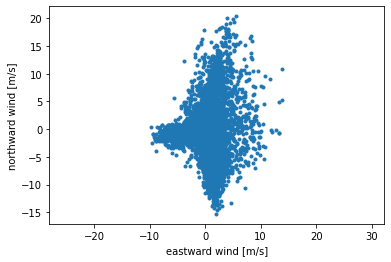

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from airsea.windstress import stress

def wind_uv_from_spddir(wspd,wdir):
    theta = np.array(wdir)
    theta = theta*np.pi/180
    x = np.sin(theta)
    y = np.cos(theta)
    theta_cart = np.arctan2(y,x)
    u = -wspd*np.cos(theta_cart) #why should these be negative?
    v = -wspd*np.sin(theta_cart)
    return u,v

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

ncfile = 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/nwpo3/nwpo3h2019.nc'
ds = xr.open_dataset(ncfile)

ds = ds.squeeze()

#get and plot alignment of wind velocity 

ds['wind_east'],ds['wind_north'] = wind_uv_from_spddir(ds['wind_spd'], ds['wind_dir'])


plt.plot(ds['wind_east'],ds['wind_north'],'.')
plt.xlabel('eastward wind [m/s]')
plt.ylabel('northward wind [m/s]')
plt.axis('equal')


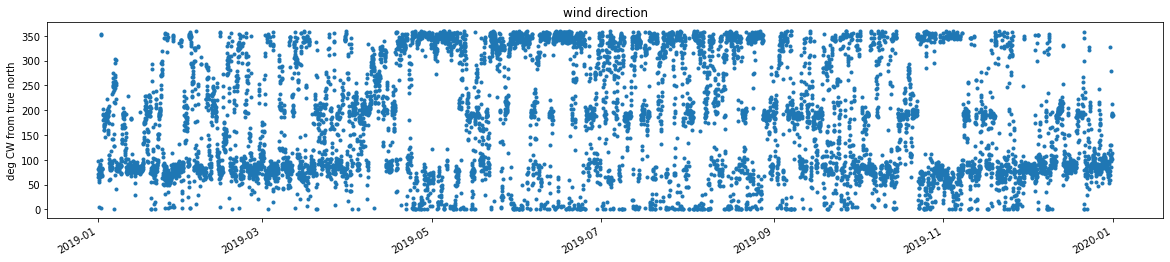

In [8]:
plt.figure(figsize=(20,4))
plt.plot(ds['time'],ds['wind_dir'], linestyle='None', marker='.')
plt.title('wind direction')
plt.ylabel('deg CW from true north')
plt.gcf().autofmt_xdate()

In [ ]:
datasets = []

for i in ds['wind_dir']:
    if i<=330 and i>=300:
        datasets.append(True)
    else:
        datasets.append(False)


ds['upwell_fav'] = (['time'], datasets)
print(np.array([ds['upwell_fav'].values, ds['wind_dir']]))


plt.figure(figsize=(20,4))
plt.bar(ds['time'],ds['upwell_fav'])
plt.title('Times for Wind Direction b/t 300 and 330 deg from TN')
plt.gcf().autofmt_xdate()

[[  0.   0.   0. ...   0.   0.   0.]
 [ 81.  97.  66. ... 190. 194. 190.]]


In [ ]:
#get and plot wind stress

ds['wind_east'],ds['wind_north'] = wind_uv_from_spddir(ds['wind_spd'], ds['wind_dir'])

tau = stress(ds['wind_spd'],z=4.1)
#wind stress in same direction as wind velocity, so get theta from arctan2 then use this to find components of tau
tau_east = tau*np.cos(np.arctan2(ds['wind_north'],ds['wind_east']))
tau_north = tau*np.sin(np.arctan2(ds['wind_north'],ds['wind_east']))

ds['tau_east'] = (('time'), tau_east)
ds['tau_north'] = (('time'), tau_north)

plt.figure(figsize=(10,4))
plt.plot(ds['time'],ds['tau_east'])
plt.plot(ds['time'],ds['tau_north'])
plt.ylabel('[N/m$^2$]')
plt.title('wind stress')
plt.legend(['$\\tau^{se}$','$\\tau^{sn}$'])

plt.figure(figsize=(10,4))
plt.plot(ds['tau_east'],ds['tau_north'], linestyle='None', marker='.')
plt.ylabel('north component')
plt.xlabel('east component')
plt.title('wind stress')
plt.axis('equal')

In [ ]:
#rotate vectors to be in alongshore & crossshore direction
theta,major,minor = princax(ds['tau_east'],ds['tau_north']) #rot angle is CCW rotation for vecotr or CW rotation for basis
print(theta)
ds['tau_x'],ds['tau_y'] = rot(ds['tau_east'],ds['tau_north'],-theta+90)

plt.figure()
plt.plot(ds['tau_x'],ds['tau_y'],'.')
plt.axis('equal')
plt.xlabel('stress in crossshore-direction ($\\tau^{sc}$)')
plt.ylabel('stress in alongshore-direction ($\\tau^{sa}$)')
plt.title('rotated coordinates')


plt.figure(figsize=(10,4))
plt.plot(ds['time'],ds['tau_x'])
plt.plot(ds['time'],ds['tau_y'])
plt.ylabel('[N/m$^2$]')
plt.title('wind stress')
plt.legend(['$\\tau^{sc}$','$\\tau^{sa}$'])

In [ ]:
rho = 1026 #denisty of sea water kg/m3
f = 2*7.292115*10**-5*np.sin(ds['latitude'].values*np.pi/180) #coriolis parameter 1/s

ds['uek'] = (('time'), ds['tau_y']/(rho*f))

plt.figure()
plt.plot(ds['time'],100*ds['uek'])
plt.ylabel('[m$^3$ s$^{-1}$ / 100m]')
plt.title('Ekman Transport')